# STATS 542: Homework 12
<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Apr 27th </center></h4>

## About HW12

You should implement a stump model which consists of just one split. Use the stump model as the base learner in AdaBoost, following the algorithm we introduced. 

## Question 1 [40 Points] The Stump Model Base Learner

The stump model is a CART model with just one split, hence having two terminal nodes. The key is to find a splitting rule (with a splitting variable and a cutting point), and properly record the fitted value at each terminal node. For this question, we use a one-dimensional example, so only the cutting point needs to be searched. An additional difficulty is that we need to incorporate subject weights, which is used in AdaBoost. The data is generated with the following code. There is also a set of testing data which will be used later. 

```r
  set.seed(5)
  n = 200
  x = runif(n)
  py <- function(x) sin(4*pi*x)/3 + 0.5
  y = (rbinom(n, 1, py(x))-0.5)*2
  
  plot(x, y + 0.1*runif(n, -1, 1), ylim = c(-1.1, 1.1), pch = 19, 
       col = ifelse(y == 1, "darkorange", "deepskyblue"), ylab = "y")
  lines(sort(x), py(x)[order(x)] - 0.5)
  
  testx = seq(0, 1, length.out = 1000)
  testy = (rbinom(1000, 1, py(testx))-0.5)*2
```

The stump model works this way:

  * __Input__: A set of data ${\cal D}_n =  \{x_i, y_i, w_i\}_{i=1}^n$
  * __Output__: The cutting point $c$, and node predictions $f_L, f_R \in \{-1, 1\}$
  * __Step 1__: Search for a splitting rule $\mathbf{1}(x \leq c)$ that maximizes the weighted reduction of Gini impurity.
$$ \texttt{score} = - \, \frac{\sum_{ {\cal T}_L} w_i}{\sum w_i} \text{Gini}({\cal T}_L) - \frac{\sum_{ {\cal T}_R} w_i}{\sum w_i} \text{Gini}( {\cal T}_R ),$$ where, for given data in a potential node ${\cal T}$, the weighted version of Gini impurity is
$$ \text{Gini}({\cal T}) = \widehat p (1- \widehat p), \qquad \widehat p = (\textstyle \sum w_i)^{-1} \textstyle\sum w_i I(y_i = 1).$$
  * __Step 2__: Calculate and record the left and the right node prediction values $f_L, f_R \in \{-1, 1\}$ respectively. Note you also need to incorporate the weights in these calculations. 

You should write a function called `myStump(x, y, w)` that outputs the cutoff point, and the left and right predictions. Once your finish the stump model algorithm, test your code in the following two scenarios:
  * All training data has equal weights
  * Observations with $x \geq 0.5$ has weights 2, while observations with $x < 0.5$ has weights 0.1.

**Note:** I ran the R code above to generate the data files `HW12_x.csv`, `HW12_y.csv`, `HW12_x_test.csv` and `HW12_y_test.csv`. They have been included in the HW submission.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')

In [2]:
x = np.loadtxt("HW12_x.csv", skiprows=1)
y = np.loadtxt("HW12_y.csv", skiprows=1)
test_x = np.loadtxt("HW12_x_test.csv", skiprows=1)
test_y = np.loadtxt("HW12_y_test.csv", skiprows=1)

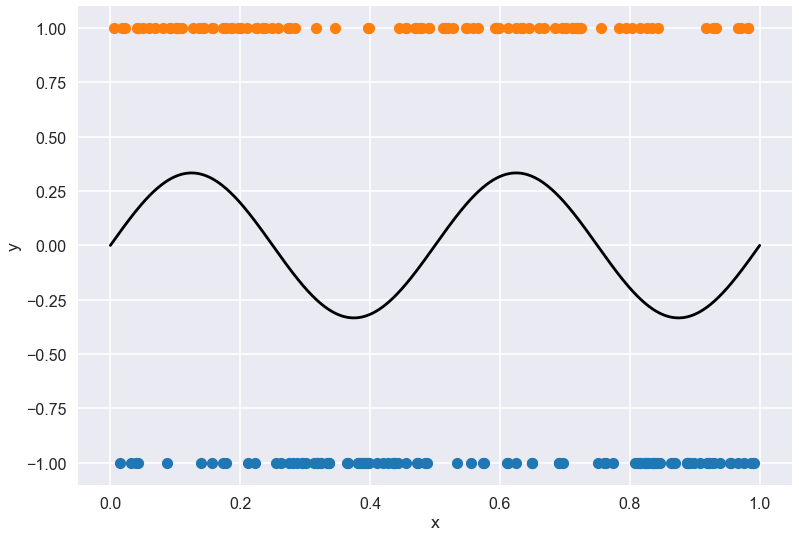

In [3]:
x_neg = x[np.where(y < 0)]
x_pos = x[np.where(y > 0)]
y_neg = y[np.where(y < 0)]
y_pos = y[np.where(y > 0)]
plt.plot(x_neg, y_neg, 'o')
plt.plot(x_pos, y_pos, 'o')
line_x = np.linspace(0, 1, 1000)
line_y = np.sin(4*np.pi*line_x)/3
plt.plot(line_x, line_y, c='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
def myStump(x, y, w):
    '''
    One dimensional implementation of a stump model base learner for classification.
    '''
    assert(x.shape == y.shape == w.shape)
    
    # Since the data is one dimensional, we don't need to iterate over the variables
    # We iterate over all possible cutoff values to find the maximum Gini impurity reduction
    
    # Sort x (and y)
    sorted_idx = np.argsort(x)
    x_sorted = x[sorted_idx]
    y_sorted = y[sorted_idx]
    w_sorted = w[sorted_idx]
    
    # Find cutoff value
    # We "move" an x value from the right node to the left node (in order) in each 
    # iteration and if the Gini impurity reduction is better, we update the cutoff
    # value to the x value that was just moved
    
    score_prev = -1
    for i in range(1, x.shape[0]):
        # Split data
        left = x_sorted[:i]
        left_y = y_sorted[:i]
        left_w = w_sorted[:i]
        
        right = x_sorted[i:]
        right_y = y_sorted[i:]
        right_w = w_sorted[i:]
        
        # Compute prediction values and Gini impurity reduction
        gini_reduction_left = gini_impurity_reduction(left_y, left_w, w_sorted)
        gini_reduction_right = gini_impurity_reduction(right_y, right_w, w_sorted)
        score = gini_reduction_left + gini_reduction_right
        
        if (score > score_prev):
            cutoff = i
            score_prev = score
    
    # Find prediction values
    left_y = y_sorted[:cutoff]
    left_w = w_sorted[:cutoff]
    right_y = y_sorted[cutoff:]
    right_w = w_sorted[cutoff:]
    
    left_prediction, right_prediction = get_prediction(left_y, left_w), get_prediction(right_y, right_w)
    
    cutoff_value = x_sorted[cutoff]
    
    return cutoff_value, left_prediction, right_prediction

def gini_impurity_reduction(y, w, w_all):
    '''
    Computes Gini impurity reduction for one node.
    
    y and w are the labels and weights for the data in the given node.
    w_all are the weights for the entire training set.
    '''
    
    p = w[np.where(y == 1)].sum()/w.sum()
    gini = p*(1-p)
    
    return -w.sum()/w_all.sum()*gini

def get_prediction(y, weights):
    '''
    Returns prediction value for a node (classification problem). 
    
    The return value is either -1 or 1.
    '''
    return np.sign((y*weights).sum()/weights.sum())

#### Test 1: equal weights

In [5]:
n = x.shape[0]
w = np.ones(n)/n

In [6]:
c, fL, fR = myStump(x, y, w)

In [7]:
print("Cutoff point:", c)
print("Left prediction:", fL)
print("Right prediction:", fR)

Cutoff point: 0.25556407077238
Left prediction: 1.0
Right prediction: -1.0


#### Test 2: change weights

In [8]:
n = x.shape[0]
w = np.empty(n)
w[np.where(x>=0.5)] = 2
w[np.where(x<0.5)] = 0.1

In [9]:
c, fL, fR = myStump(x, y, w)

In [10]:
print("Cutoff point:", c)
print("Left prediction:", fL)
print("Right prediction:", fR)

Cutoff point: 0.807935200864449
Left prediction: 1.0
Right prediction: -1.0


## Question 2 [60 Points] AdaBoost

Let's write our own code for AdaBoost which is an iterative method that calls the stump model and update the weights. Implment the formula we introduced in the lecture, and perform the following

  * You are required to implement a `shrinkage` factor $\delta$, which is commonly used in boosting algorithms. Note that the shrinkage factor essentially works on the $\alpha$ to achieve a smaller step size. 
  * You are not required to do bootstrapping for each tree (you still can if you want).
  * Calculate the classification error and the exponential loss bound $n^{-1} \sum_{i=1}\exp\{- y_i \delta \sum_k \alpha_k f_k(x_i)\}$ over the number of tree iterations for your training data. You can either record this in your fitting function or do this using a prediction function (the next step).
  * Write a prediction function for your testing data that outputs the predicted value of all testing samples over all tree iterations.
  * Plot the three quantities above over the tree iterations: training error, training exponential loss bound, and the testing error. 
  * Try two different `shrinkage` factors of this plot, and comment on your findings. Please note that you may need to adjust the number of trees so that your algorithm works well. 
  * For each of the shrinkage factor you used, plot the final model (functional value of $F$, and also the sign) with the observed data.

In [11]:
def AdaBoost(stump, x, y, initial_weights=None, shrinkage=1, T=3):
    '''
    AdaBoost implementation using stump model with one split for one dimensional binary classification problem.
    
    Arguments
    --------------
    stump: callable. Base model for AdaBoost with signature stump(x, y, w).
    x: np.ndarray of shape (n_samples,). 1-dimensional training data.
    y: np.ndarray of shape (n_samples,). Ground truth for classification labels (1 or -1).
    initial_weights: np.ndarray of shape (n_samples,). Sample weights for first iteration. 
        If not specified, the weights default to 1/n_samples.
    shrinkage: float. Shrinkage factor to scale alpha. Default 1 (no scaling).
    T: int. Number of stump models to ensemble for the grand classifier. Default 3.
    
    Returns
    --------------
    results: dict with keys
        'training_error': np.ndarray of shape (T,). Classification error after completing each tree iteration.
        'predictions_t_all': np.ndarray of shape (T, n). Predicted values from grand model for each tree iteration.
        'exp_loss_bound': np.ndarray of shape (T,). Exponential loss bound for each tree iteration.
        'model': callable. Fitted model. Can be called as model(x[, y]) to return predicted values (and testing error
            if labels are given).
    '''
    n = x.shape[0]
    if not initial_weights:
        initial_weights = np.ones(n)/n
    
    w = initial_weights
    alpha_all = np.zeros(T)
    models = np.empty((T, 3)) 
    predictions_all = np.zeros((T, n))
    predictions_t_all = np.zeros((T, n)) # This array is returned, the above one is not
    exp_loss_bound = np.zeros(T)
    training_error = np.zeros(T)
    for t in range(T):
        c, fL, fR = stump(x, y, w) # Fit classifier
        models[t] = np.asarray([c, fL, fR]) # Store parameters for each stump
        predictions = np.asarray([fL if xi < c else fR for xi in x]) # Predictions from the stump
        predictions_all[t] = predictions # Store predictions to compute loss bound
        epsilon = (w[np.where(predictions != y)]).sum()
        alpha = shrinkage*(0.5)*np.log((1-epsilon)/epsilon)
        alpha_all[t] = alpha # Store alpha because it is needed for the grand model
        Z = (np.exp(-alpha*y*predictions)*w).sum()
        w = w/Z*np.exp(-alpha*y*predictions) # Update weights
        
        # The loss bound and the training error have to be computed using predictions
        # from the grand model at step t
        
        # Alpha was already multiplied by the shrinking factor
        predictions_t = (alpha_all[:t+1, np.newaxis]*predictions_all[:t+1]).sum(axis=0) 
        loss_bound = (1/n*np.exp(-y*predictions_t)).sum() 
        exp_loss_bound[t] = loss_bound
        # predictions_t is not necessarily 1 or -1, we convert it to the actual predictions using np.sign()
        predictions_t_all[t] = np.sign(predictions_t)
        training_error[t] = np.count_nonzero(y != np.sign(predictions_t))/n # Compute training error at step t
    
    # Construct final fitted model to return
    model = get_model(models, alpha_all)
    
    output = {}
    output['training_error'] = training_error
    output['predictions_t_all'] = predictions_t_all
    output['exp_loss_bound'] = exp_loss_bound
    output['model'] = model
    
    return output

def get_model(models, alpha_all):
    '''
    Builds and return a fitted model from the stump models provided.
    '''
    
    def model(x, y=None):
        T = models.shape[0]
        n = x.shape[0]
        pred = np.zeros((T, n))
        predictions = np.zeros((T, n))
        raw_values = np.zeros((T, n))
        
        for t, (c, fL, fR) in enumerate(models):
            pred[t] = np.asarray([fL if xi < c else fR for xi in x])
            predictions_t = (alpha_all[:t+1, np.newaxis]*pred[:t+1]).sum(axis=0)
            raw_values[t] = predictions_t
            predictions[t] = np.sign(predictions_t)
        
        if y is not None:
            test_error = np.empty(T)
            for t in range(T):
                test_error[t] = np.count_nonzero(y != predictions[t])/n
        else:
            test_error = None
        return predictions, test_error, raw_values
    
    return model

#### Test 1: $\delta = 0.3$ and $T = 100$

In [12]:
results_test_1 = AdaBoost(myStump, x, y, shrinkage=0.3, T=100)

In [13]:
training_error = results_test_1['training_error']
exp_loss_bound = results_test_1['exp_loss_bound']
model = results_test_1['model']
test_predictions, testing_error, raw_values = model(test_x, test_y)

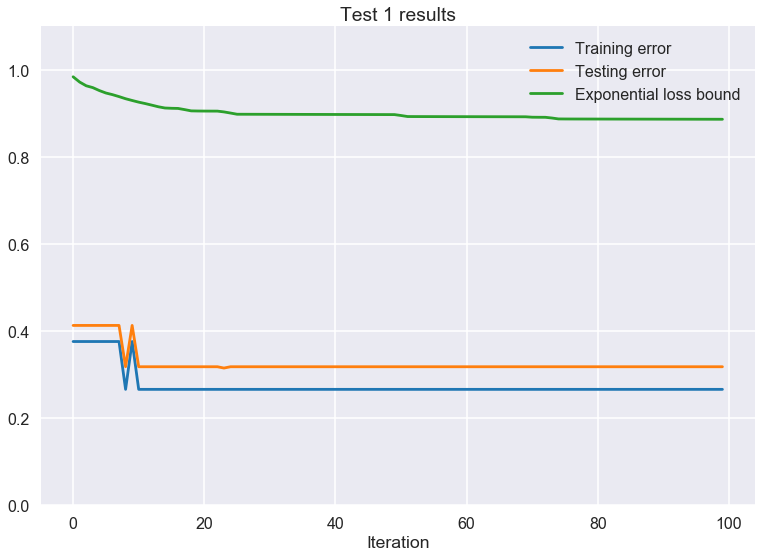

In [14]:
plt.plot(training_error)
plt.plot(testing_error)
plt.plot(exp_loss_bound)
plt.xlabel("Iteration")
plt.legend(['Training error', 'Testing error', 'Exponential loss bound'])
plt.ylim([0, 1.1])
plt.title("Test 1 results")
plt.show()
plt.close()

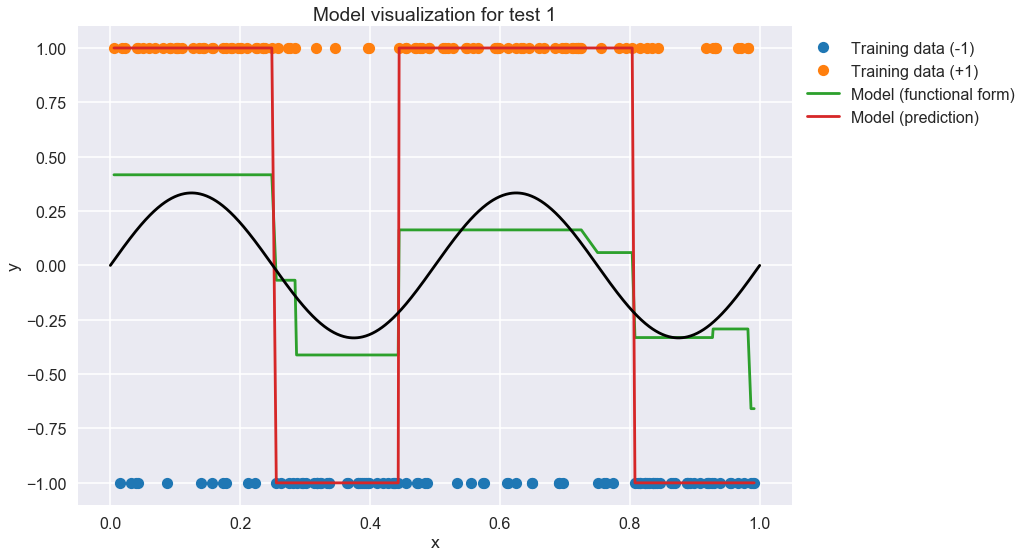

In [15]:
x_neg = x[np.where(y < 0)]
x_pos = x[np.where(y > 0)]
y_neg = y[np.where(y < 0)]
y_pos = y[np.where(y > 0)]
plt.plot(x_neg, y_neg, 'o')
plt.plot(x_pos, y_pos, 'o')
plt.plot(np.sort(x), model(np.sort(x))[-1][-1])
plt.plot(np.sort(x), model(np.sort(x))[0][-1])
line_x = np.linspace(0, 1, 1000)
line_y = np.sin(4*np.pi*line_x)/3
plt.plot(line_x, line_y, c='black')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Training data (-1)', 'Training data (+1)', 'Model (functional form)', 'Model (prediction)'],
           bbox_to_anchor=(1, 1), 
           loc='upper left', 
           ncol=1)
plt.title("Model visualization for test 1")
plt.show()

#### Test 2: $\delta = 0.9$ and $T = 100$

In [16]:
results_test_2 = AdaBoost(myStump, x, y, shrinkage=0.9, T=100)

In [17]:
training_error = results_test_2['training_error']
exp_loss_bound = results_test_2['exp_loss_bound']
model = results_test_2['model']
test_predictions, testing_error, raw_value = model(test_x, test_y)

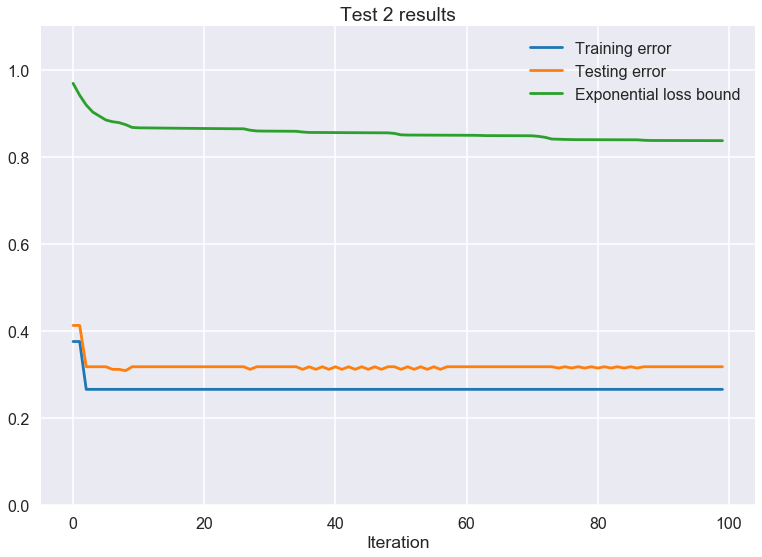

In [18]:
plt.plot(training_error)
plt.plot(testing_error)
plt.plot(exp_loss_bound)
plt.xlabel("Iteration")
plt.legend(['Training error', 'Testing error', 'Exponential loss bound'])
plt.title("Test 2 results")
plt.ylim([0, 1.1])
plt.show()
plt.close()

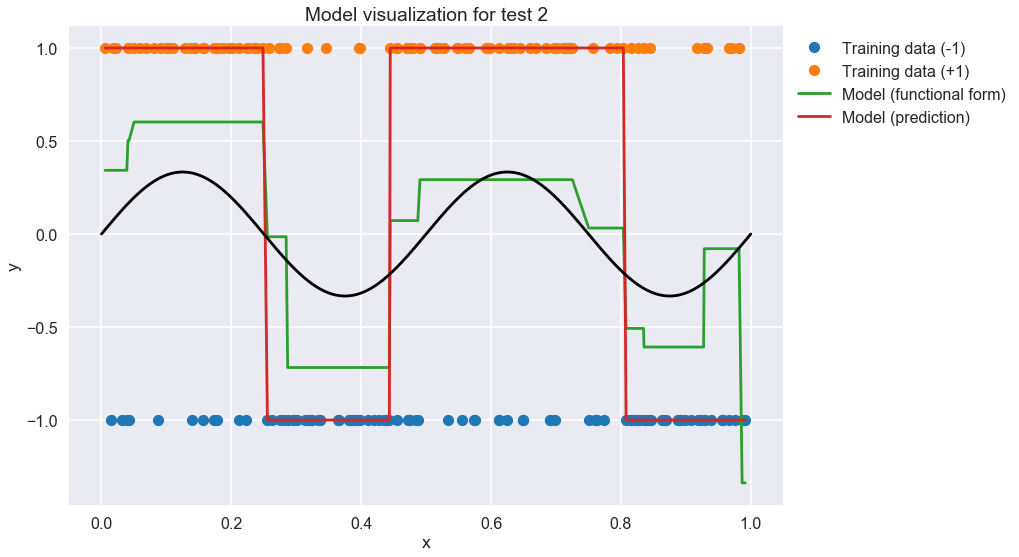

In [19]:
x_neg = x[np.where(y < 0)]
x_pos = x[np.where(y > 0)]
y_neg = y[np.where(y < 0)]
y_pos = y[np.where(y > 0)]
plt.plot(x_neg, y_neg, 'o')
plt.plot(x_pos, y_pos, 'o')
plt.plot(np.sort(x), model(np.sort(x))[-1][-1])
plt.plot(np.sort(x), model(np.sort(x))[0][-1])
line_x = np.linspace(0, 1, 1000)
line_y = np.sin(4*np.pi*line_x)/3
plt.plot(line_x, line_y, c='black')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Training data (-1)', 'Training data (+1)', 'Model (functional form)', 'Model (prediction)'],
           bbox_to_anchor=(1, 1), 
           loc='upper left', 
           ncol=1)
plt.title("Model visualization for test 2")
plt.show()

#### Conclusions

We obtained a training error of $26.5\%$ and a testing error of $31.7\%$ for both trials (test #1 and #2).

From the plotted curves, we can observe that when we use a lower $\delta$ (shrinkage), the errors and exponential bound loss decrease more slowly. Additionally, if I increased the number of iterations $T$, we would observe overfitting (training error and exponential bound loss continue to decrease but testing error increases). It is also interesting to note that higher $\delta$ values lead to some model instabilities, as observed in the oscillation of the testing error curve in test #2.

The model visualization plots (which correspond to the grand model) allow us to observe some differences between the two models. More specifically, the model trained with a higher $\delta$ seems to have a higher variance (in the functional form, the predictions are identical).